In [137]:

import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.io import wavfile

import librosa
import librosa.display
import seaborn as sns

import scipy
try:
    from pydub import AudioSegment
except:
    !pip install pydub
    from pydub import AudioSegment

try:
    from difflib import SequenceMatcher
except:
    !pip install difflib
    from difflib import SequenceMatcher

## Import

## LE JEU DE DONNEES


### Le Dataset 



In [138]:
def CreerDossierSauvegarde(ou,doss):
    nomEmplacementSauvegarde = ou + "/" + doss
    if not os.path.exists(nomEmplacementSauvegarde):
        os.mkdir(nomEmplacementSauvegarde)
        return nomEmplacementSauvegarde
    else:
        return nomEmplacementSauvegarde


In [139]:
# Le dossier de sauvegarde DRIVE
from google.colab import drive,files
drive.mount('/content/gdrive')
!ls /content

DRUM_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE"
print(os.listdir(DRUM_LEDOSSIER))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
['808', 'Clap', 'Hi-Hat', 'Kick', 'Snare', 'Open-Hat']


In [140]:
def get_all_directory(kit_path,l_veski, res = []):
    if os.path.exists(str(kit_path)):
        for fic in os.listdir(kit_path):
            ok_veski = sum([(v in fic.lower()) for v in l_veski])
            if not ok_veski:
                fic = kit_path + "/" + fic
                if os.path.isdir(fic): #si dossier
                    res.append(fic)
                    res = get_all_directory(fic,l_veski,res)
    
    return list(sorted(list(set(res))))

l_dossiers_veski = ['fx','bonus',"loops",'melodies', 'mixer','riser', 'scales', 'master' ]
all_dossiers_a_analyser_DOSSIER = get_all_directory(DRUM_LEDOSSIER,l_dossiers_veski)
all_dossiers_a_analyser_DOSSIER

['/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808',
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Clap',
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Hi-Hat',
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Kick',
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Open-Hat',
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Snare']

In [141]:
def get_names_files_on(doss):
    listeFichiersAUDIO =  np.array([doss + "/" + fic for fic in os.listdir(doss) if fic.split(".")[-1] in ["wav"]  ])
    return listeFichiersAUDIO 

print(get_names_files_on(all_dossiers_a_analyser_DOSSIER[0]))


['/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/808 (9) [Cono].wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/808Star (9).wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/PluckStar [Pagaye].wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/808Star (8).wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/nm - 12oz 808.wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/nm - audi 808.wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/808Star (6).wav'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/808/NM - Baands 808.wav

In [142]:
test1 = get_names_files_on(all_dossiers_a_analyser_DOSSIER[1])[0]
test2 = get_names_files_on(all_dossiers_a_analyser_DOSSIER[1])[1]

In [143]:
one_seconds = 1000
def AfficherAudio(filename_list, cut_sec):
    if filename_list:
        song = AudioSegment.from_wav(filename_list[0])[0:one_seconds* cut_sec]
        if len(filename_list) > 1:
            try:
                for f in filename_list[1:]:
                    song += AudioSegment.from_wav(f)[0:one_seconds* cut_sec]
            except:
                print("*")

    return song

AfficherAudio([test1,test2],0.4)

In [144]:
def plus_grand_power(liste,N = 3):
    liste = list(liste)
    res = []
    resi = []
    base = liste[:]
    somme = 0
    for k in range(N):
        i = liste.index(max(liste) )
        m = liste.pop(i)
        somme += m

        resi.append( base.index( m) )
        res.append( m )
    return res,resi, round(somme/N,5)

def plus_grand_freq(psd,freqs, N = 5):
    grands_power, grands_power_index,grands_moy = plus_grand_power(psd,N)
    return freqs[grands_power_index], freqs[grands_power_index].mean()

from scipy.io import wavfile

def frequency(song_path): # TODO : faire un frequency 2 qui regle pb de 24-bit
    ok = True
    try:
        sampFreq, sound = wavfile.read(song_path)
    except:
        ok = False

    if ok:
        sound = sound / 2.0**15
        length_in_s = sound.shape[0] / sampFreq
        time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s

        if len(sound.shape) > 1:
            signal = sound[:,0]
        else:
            signal = sound
        fft_spectrum = np.fft.rfft(signal)
        freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)

        fft_spectrum_abs = np.abs(fft_spectrum)
        return round(plus_grand_freq(fft_spectrum_abs,freq, 50)[1],3)
    return np.NaN

frequency(test2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: WavFileWarning: Chunk (non-data) not understood, skipping it.


3514.544

In [145]:
import soundfile as sf

def duration(song_path):
    f = sf.SoundFile(song_path)
    return round(len(f) / f.samplerate,2)

duration(test1)

0.07

In [146]:
# trim audio wav : http://www.janpijpers.com/trim-wave-file-example-with-scipy/

In [147]:
def data_from_doss(doss):
    col_names, col_freqs,col_durations, col_labels, col_src = [],[],[],[],[]
    for i, dir_drums in enumerate(all_dossiers_a_analyser_DOSSIER):
        listeFichiersAUDIO = get_names_files_on(dir_drums)

        if len(listeFichiersAUDIO) > 0:
            for fic_audio in listeFichiersAUDIO:
                col_names.append(fic_audio.split('/')[-1].split('.')[0])
                col_freqs.append(frequency(fic_audio))
                col_durations.append(duration(fic_audio))
                col_src.append(fic_audio)
                col_labels.append(dir_drums.split("/")[-1])
    return pd.DataFrame.from_dict( {'name': col_names,'freq':col_freqs,'duration': col_durations, 'src': col_src, 'Class': col_labels} )

DF_TOTAL = data_from_doss(all_dossiers_a_analyser_DOSSIER)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: WavFileWarning: Chunk (non-data) not understood, skipping it.


In [148]:
print(np.shape(DF_TOTAL))
DF_TOTAL.head(10)

(273, 5)


,name,freq,duration,src,Class
0,808 (9) [Cono],52.293,3.79,/content/gdrive/Shareddrives/# Zone de Code #/...,808
1,808Star (9),73.562,2.89,/content/gdrive/Shareddrives/# Zone de Code #/...,808
2,PluckStar [Pagaye],NaN,2.71,/content/gdrive/Shareddrives/# Zone de Code #/...,808
3,808Star (8),NaN,1.24,/content/gdrive/Shareddrives/# Zone de Code #/...,808
4,nm - 12oz 808,113.941,1.68,/content/gdrive/Shareddrives/# Zone de Code #/...,808
5,nm - audi 808,43.324,7.28,/content/gdrive/Shareddrives/# Zone de Code #/...,808
6,808Star (6),61.000,3.24,/content/gdrive/Shareddrives/# Zone de Code #/...,808
7,NM - Baands 808,67.161,7.02,/content/gdrive/Shareddrives/# Zone de Code #/...,808
8,NM - Aashes 808,47.958,7.39,/content/gdrive/Shareddrives/# Zone de Code #/...,808
9,NM - Audi 2 808,56.101,6.62,/content/gdrive/Shareddrives/# Zone de Code #/...,808


In [149]:
DF_TOTAL.dropna(inplace=True)
DF_TOTAL.reset_index(drop=True,inplace=True)
print(np.shape(DF_TOTAL))

(255, 5)


### Visualisation


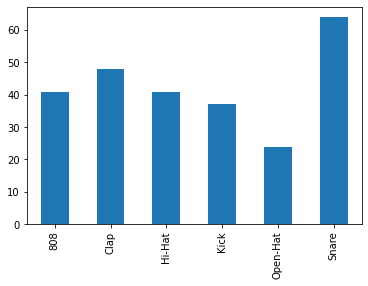

In [150]:
DF_TOTAL['Class'].value_counts().sort_index().plot(kind='bar')


In [151]:
DF_TOTAL[ DF_TOTAL["Class"] == "Clap"]

,name,freq,duration,src,Class
41,NM - Miracle (Clap),1669.740,0.07,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
42,NM - Minute (Clap),3514.544,0.08,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
43,NM - Blocc (Clap),1285.723,0.12,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
44,NM - Virgil (Clap),1578.145,0.23,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
45,nm - lwh clap,2268.672,0.08,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
46,NM - Formant Clap,1646.298,0.18,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
47,NM - Eighty Clap,1953.193,0.07,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
48,NM - Auto Clap,1346.178,0.16,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
49,NM - Wildfire Clap,2762.206,0.13,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap
50,nm - dune snap,2160.764,0.06,/content/gdrive/Shareddrives/# Zone de Code #/...,Clap


In [152]:
def tracer_graph(df,abs,hor,title="*"):
    plt.title(title)
    df = df.sort_values(by=['Class']) 
    # pour chaque classe
    for cl in df.iloc[:,-1].unique():
        df_class = df.loc[ df["Class"] == cl]

        plt.scatter(df_class[abs],df_class[hor], label=cl,zorder=1)
        # Annotations du graphique
        plt.xlabel(str(abs))
        plt.ylabel(str(hor))   
        plt.legend()


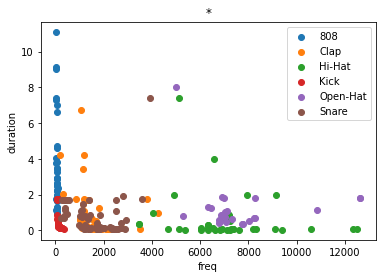

In [153]:
tracer_graph(DF_TOTAL,"freq","duration")

### Separation TRAIN


In [154]:
def train_test_split(df,test_size=0.15):
    ok = False
    while not ok:
        train_df = df.sample(frac=(1-test_size), random_state=200)
        test_df = df[~df.index.isin(train_df.index)]
        ok = True
        for e in test_df['Class'].value_counts().to_numpy():
            if e < 1:
                ok = False

    return train_df,test_df,train_df.iloc[:,:-1].to_numpy() ,train_df.iloc[:,-1].to_numpy(), test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()

DF_TRAIN,DF_TEST,X_TRAIN,Y_TRAIN, X_TEST, Y_TEST = train_test_split(DF_TOTAL)

print(np.shape(X_TRAIN))
print(np.shape(Y_TRAIN))
print(np.shape(X_TEST))
print(np.shape(Y_TEST))

(217, 4)
(217,)
(38, 4)
(38,)


##IMPLEMENTATION


### Algo KNN


In [155]:
def distance(p1,p2): #distance euclidienne
    res = 0

    coeff_name, coeff_freq = 1,1
    """
    Entrée:
        p1: un point
        p2: un deuxième point
        
    Sortie:
        renvoie la distance entre les deux point """

    if len(p1) == len(p2):
        # name
        ratio = 1 - SequenceMatcher(None,p1[0],p2[0]).ratio()
        dist_name = ratio*50 #prend 50pts si trop diff
        #print("name",dist_name,"---",p1[0],p2[0])
        #freq
        dist_freq = abs(p1[1] - p2[1] )
        #print("freq",dist_freq,"---",p1[1],p2[1])

        #duration
        dist_duration = abs(p1[2] - p2[2])
        #print("dura",dist_duration,"---",p1[2],p2[2])
        return dist_name + dist_freq
    else:
        return None

p1 = X_TRAIN[0]
p2 = X_TRAIN[9]
#print(p1)
#print(p2)
distance(p1,p2)

1534.9741111111111

In [156]:
def knn(point, k=3):
    global X_TRAIN
    """
    Entrée:
        point: un point
        k: nombre de voisins les plus proches à utiliser(par défaut 3)
        
    Sortie:
        renvoie les k plus proches voisins, leurs indices """
    distances_voisins = [] 
    for index, p in enumerate(X_TRAIN): # pour chaque ligne ~ chq point du data

        comparison = p == point
        equal_arrays = comparison.all()
        if not equal_arrays:
            dist = distance(point,p) #distance entre p et le point étudié
            distances_voisins.append((dist,index))

    
    distances_voisins = sorted(distances_voisins) #tri selon le 1er arg du tuple, donc dist
    indices = [index for d,index in distances_voisins[:k]]
    return indices, X_TRAIN[indices] #retourne les indices des k plus proches voisins de point

p1 = X_TRAIN[8]
print(p1[0])
knn(p1,3)

Drumkit (16)


([20, 118, 74], array([['Snare (4) [Kilometrage]', 3921.298, 7.4,
         '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Snare/Snare (4) [Kilometrage].wav'],
        ['Clap 5 (Wixie Beatz)', 3820.472, 1.73,
         '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Clap/Clap 5 (Wixie Beatz).wav'],
        ['Snare 1 (Wixie Beatz)', 3606.395, 1.74,
         '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/• DRUM for KNN/BASE/Snare/Snare 1 (Wixie Beatz).wav']],
       dtype=object))

# NM - Virgil (Clap)


('Clap', 100.0)

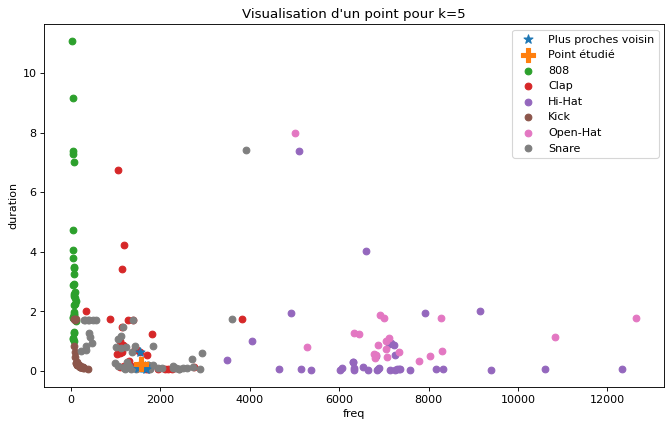

In [157]:
def prediction(point,k,afficherGraphe = False,nombrePrediction=1): #prediction pour un point
    global Y_TRAIN
    """Pour un point, on envoie la classe des k plus proches voisins
    
    Entrée:
        point: le point
        X: nb de 1/2j d'absences lors du trimestre
        k: nombre de voisins les plus proches à utiliser(par défaut 3)
        
    Sortie:
        renvoie les classe la plus probable des k plus porches voisins"""

    indices_k_proches_voisins,k_proches_voisins = knn(point,k)

    # on va compter les classes des voisins
    compt = {}
    for i in indices_k_proches_voisins: # pour chq voisins
        
        laClassDuVoisin = Y_TRAIN[i] # on recup la class du voisins

        # on incrémente dans le dictionnaire
        if laClassDuVoisin in compt.keys(): 
            compt[laClassDuVoisin] = compt[laClassDuVoisin] + 1
        else:
            compt[laClassDuVoisin] = 1
   
    # obtenir pourcentage
    for key, val in compt.items():
        compt[key] = round(val/k*100,2)
    
    # trier par ordre croissant de pourcentage
    compt = sorted(compt.items(), key=lambda t: t[1])
    predict = compt[-nombrePrediction:] # retourner le dernier element, la classe avec le plus grand pourcentage
    # afficher Graphe
    if afficherGraphe:
        # on commence par afficher notre point sur un graphique
        col_abs = "freq"
        col_ord = "duration"

        
        plt.scatter(X_TRAIN[indices_k_proches_voisins,1], X_TRAIN[indices_k_proches_voisins,2], label="Plus proches voisin", marker="*",zorder=8, s=70)
        plt.scatter(point[1], point[2], label="Point étudié", marker="P",zorder=10, s=150)
        tracer_graph(DF_TRAIN,col_abs,col_ord,"Visualisation d'un point pour k="+str(k),) # on affiche le point avec tous les autres point dans TRAIN !
    return predict # return classse prédit, % de ses voisins

plt.figure(figsize=(10, 6), dpi=80)    

p1 = X_TRAIN[9]
print("#",p1[0])
prediction(p1,5,True)[-1]

###• (Training Step)


In [158]:
def PredireClassYfromX(X,k): 
    """ Prédire les class d'un ensemble de point
    Entrée:
        X: les points (une point = une ligne)
        k: nombre de voisins les plus proches à prendre en compte
        
    Sortie:
        renvoie Y, les classes la plus probable des k plus porches voisins
    """
    Y_predicted = []
    print("PredireClassYfromX() Loading:",end="")
    for i, p in enumerate(X):
        print(f"{int(round(i/len(X)*100,1))}%",end=".. ")
        Y_predicted.append( prediction(p,k)[-1][0] ) #la classe prédite pour le point p
    print()
    return np.array(Y_predicted)

In [159]:
def confusion(X_actual,X_predicted):
    """ Matrice de confusion
    Entrée:
        X_actual: les vrai classes
        X_predicted: les classes prédites
        
    Sortie:
        renvoie Y, les classes la plus probable des k plus porches voisins
    """
    go = {'x_Actual': X_actual,
          'x_Predicted':X_predicted
        }
    #print("*")
    df = pd.DataFrame(go, columns=['x_Actual','x_Predicted'])
    confusion_matrix = pd.crosstab(df['x_Actual'], df['x_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    #print(confusion_matrix.to_numpy())
    #print("*!")
    precision = 0
    for j in range(len(confusion_matrix.index)):
        #print("*!!",j)
        precision += confusion_matrix.iloc[j][j]
    
        #print(precision,somme)
    precision /= confusion_matrix.to_numpy().sum()
    #print("fin")
    return confusion_matrix,precision 

In [160]:
K = 3
Y_TRAINPredicted = PredireClassYfromX(X_TRAIN,K)

PredireClassYfromX() Loading:0%.. 0%.. 0%.. 1%.. 1%.. 2%.. 2%.. 3%.. 3%.. 4%.. 4%.. 5%.. 5%.. 6%.. 6%.. 6%.. 7%.. 7%.. 8%.. 8%.. 9%.. 9%.. 10%.. 10%.. 11%.. 11%.. 12%.. 12%.. 12%.. 13%.. 13%.. 14%.. 14%.. 15%.. 15%.. 16%.. 16%.. 17%.. 17%.. 18%.. 18%.. 18%.. 19%.. 19%.. 20%.. 20%.. 21%.. 21%.. 22%.. 22%.. 23%.. 23%.. 24%.. 24%.. 24%.. 25%.. 25%.. 26%.. 26%.. 27%.. 27%.. 28%.. 28%.. 29%.. 29%.. 30%.. 30%.. 30%.. 31%.. 31%.. 32%.. 32%.. 33%.. 33%.. 34%.. 34%.. 35%.. 35%.. 35%.. 36%.. 36%.. 37%.. 37%.. 38%.. 38%.. 39%.. 39%.. 40%.. 40%.. 41%.. 41%.. 41%.. 42%.. 42%.. 43%.. 43%.. 44%.. 44%.. 45%.. 45%.. 46%.. 46%.. 47%.. 47%.. 47%.. 48%.. 48%.. 49%.. 49%.. 50%.. 50%.. 51%.. 51%.. 52%.. 52%.. 53%.. 53%.. 53%.. 54%.. 54%.. 55%.. 55%.. 56%.. 56%.. 57%.. 57%.. 58%.. 58%.. 59%.. 59%.. 59%.. 60%.. 60%.. 61%.. 61%.. 62%.. 62%.. 63%.. 63%.. 64%.. 64%.. 65%.. 65%.. 65%.. 66%.. 66%.. 67%.. 67%.. 68%.. 68%.. 69%.. 69%.. 70%.. 70%.. 71%.. 71%.. 71%.. 72%.. 72%.. 73%.. 73%.. 74%.. 74%.. 75%.. 75%.. 76%

In [161]:
M, precis = confusion(Y_TRAIN,Y_TRAINPredicted)
print(f" --- Matrice de Confusion pour K={K} :\n", M)
print("\n --- Précision (train accuracy) :",round(precis*100,1),"%" )

 --- Matrice de Confusion pour K=3 :
 Predicted  808  Clap  Hi-Hat  Kick  Open-Hat  Snare
Actual                                             
808         33     0       0     1         0      0
Clap         0    24       0     0         0     16
Hi-Hat       0     0      26     0         9      2
Kick         3     0       0    25         0      1
Open-Hat     0     0      15     0         6      0
Snare        0    15       0     4         0     37

 --- Précision (train accuracy) : 69.6 %


In [162]:
def TrouverMeilleurK(X,Y_actual):
    k_choix = [2,3, 4,5,6, 10]
 
    abscisse = np.array(k_choix)
    ordonnee = []
    for k in abscisse:
        print("wait.. k=",k)
        Y_Predicted = PredireClassYfromX(X,k)
        ordonnee.append(confusion(Y_actual,Y_Predicted)[1])
    ymax = max(ordonnee)
    xpos = ordonnee.index(ymax)
    xmax = abscisse[xpos]
    print("end TrouverMeilleurK()")
    return abscisse,ordonnee,xmax, ymax

In [163]:
ABS_k, ORD_accuracy, meilleurK,meilleurAccuracy = TrouverMeilleurK(X_TRAIN,Y_TRAIN)

wait.. k= 2
PredireClassYfromX() Loading:0%.. 0%.. 0%.. 1%.. 1%.. 2%.. 2%.. 3%.. 3%.. 4%.. 4%.. 5%.. 5%.. 6%.. 6%.. 6%.. 7%.. 7%.. 8%.. 8%.. 9%.. 9%.. 10%.. 10%.. 11%.. 11%.. 12%.. 12%.. 12%.. 13%.. 13%.. 14%.. 14%.. 15%.. 15%.. 16%.. 16%.. 17%.. 17%.. 18%.. 18%.. 18%.. 19%.. 19%.. 20%.. 20%.. 21%.. 21%.. 22%.. 22%.. 23%.. 23%.. 24%.. 24%.. 24%.. 25%.. 25%.. 26%.. 26%.. 27%.. 27%.. 28%.. 28%.. 29%.. 29%.. 30%.. 30%.. 30%.. 31%.. 31%.. 32%.. 32%.. 33%.. 33%.. 34%.. 34%.. 35%.. 35%.. 35%.. 36%.. 36%.. 37%.. 37%.. 38%.. 38%.. 39%.. 39%.. 40%.. 40%.. 41%.. 41%.. 41%.. 42%.. 42%.. 43%.. 43%.. 44%.. 44%.. 45%.. 45%.. 46%.. 46%.. 47%.. 47%.. 47%.. 48%.. 48%.. 49%.. 49%.. 50%.. 50%.. 51%.. 51%.. 52%.. 52%.. 53%.. 53%.. 53%.. 54%.. 54%.. 55%.. 55%.. 56%.. 56%.. 57%.. 57%.. 58%.. 58%.. 59%.. 59%.. 59%.. 60%.. 60%.. 61%.. 61%.. 62%.. 62%.. 63%.. 63%.. 64%.. 64%.. 65%.. 65%.. 65%.. 66%.. 66%.. 67%.. 67%.. 68%.. 68%.. 69%.. 69%.. 70%.. 70%.. 71%.. 71%.. 71%.. 72%.. 72%.. 73%.. 73%.. 74%.. 74%.. 75%

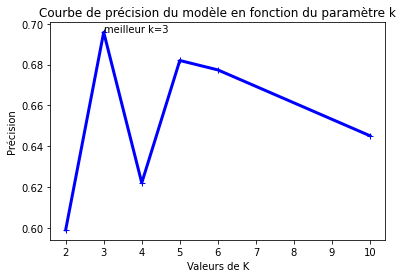

In [164]:
fig, ax = plt.subplots()
plt.title('Courbe de précision du modèle en fonction du paramètre k')
ax.plot(ABS_k,ORD_accuracy , "b-+", linewidth=3)
plt.ylabel('Précision')
plt.xlabel('Valeurs de K')

ax.annotate("meilleur k="+str(meilleurK), xy=( meilleurK,meilleurAccuracy ))

plt.show()

###• (Test Step)


In [165]:
Y_TESTPredicted = PredireClassYfromX(X_TEST,5)

PredireClassYfromX() Loading:0%.. 2%.. 5%.. 7%.. 10%.. 13%.. 15%.. 18%.. 21%.. 23%.. 26%.. 28%.. 31%.. 34%.. 36%.. 39%.. 42%.. 44%.. 47%.. 50%.. 52%.. 55%.. 57%.. 60%.. 63%.. 65%.. 68%.. 71%.. 73%.. 76%.. 78%.. 81%.. 84%.. 86%.. 89%.. 92%.. 94%.. 97%.. 


###• (Evaluation Step)

In [166]:
M, precis = confusion(Y_TEST,Y_TESTPredicted)
print(f" --- Matrice de Confusion pour K={meilleurK}:\n", M)
print("\n --- Précision (test accuracy) :",round(precis*100,1),"%" )

 --- Matrice de Confusion pour K=3:
 Predicted  808  Clap  Hi-Hat  Kick  Open-Hat  Snare
Actual                                             
808          7     0       0     0         0      0
Clap         0     1       1     1         0      5
Hi-Hat       0     0       3     0         0      1
Kick         3     0       0     5         0      0
Open-Hat     0     0       2     0         1      0
Snare        0     1       0     0         0      7

 --- Précision (test accuracy) : 63.2 %


## GO


### importation et visualisation

### les prédictions

### sauvegarde dans un fichier txt